## - Import

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import h5py
from numpy import expand_dims

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.2.1+cu118
device: cuda


## - Parameters

In [3]:
# Data

img_size = 64 # Image size
batch_size = 64  # Batch size

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 15  # Train epochs
learning_rate = 1e-4

## - Pytorch Dataset, DataLoader: Fashion MNIST

In [4]:
class_list = ['Pedestrian', 'Motorcycle', 'CAR Straight', 'CAR Side-Dia.']
class_num = len(class_list)

In [5]:
def data_extract(images_size,BATCH_SIZE=20):
    x_start = int((100-images_size[0])/2)
    x_limit=(x_start,x_start+images_size[0])
    print(x_limit)
    y_start = int((160-images_size[1])/2)
    y_limit=(y_start,y_start+images_size[1])
    print(y_limit)
    a = np.load("C:\\Users\\KRISHNA\\Desktop\\ALL GAN FINAL\\Dataset_19200_train_4800_test\\Dataset_19200_train_4800_test.npz","r")
    x1 = a["X_train"]
    x1d = x1[:,x_limit[0]:x_limit[1],y_limit[0]:y_limit[1]] # [:,18:82,48:112]
    x1d = (x1d- 127.5) / 127.5
    y1 = a["y_train"]
    lbl_len_y1 = y1.shape[0]
    remain_y1 = lbl_len_y1 % BATCH_SIZE
    print(remain_y1) 
    x2 = a["X_test"]
    x2d = x2[:,x_limit[0]:x_limit[1],y_limit[0]:y_limit[1]] #  [:,18:82,48:112]
    x2d = (x2d - 127.5) / 127.5
    y2 = a["y_test"]
    lbl_len_y2 = y2.shape[0]
    remain_y2 = lbl_len_y2 % BATCH_SIZE
    print(remain_y2)  
    train_list = list()
    lbl_lst = list()
    test_list = list()
    for i in range(y1.shape[0]-remain_y1):
        d=x1d[i]
        d1 = expand_dims(d, axis=0)
    
        train_list.append((d1,label_list[f"{vali}"]))
    for j in range(y2.shape[0]-remain_y2):
        c=x2d[j]
        c1 = expand_dims(c, axis=0)
    ysort = list(set(lbl_lst))
    ysort.sort()
    print(ysort)
    data = (train_list,test_list)
    return data,ysort,label_list

In [6]:
images_size= (img_size,img_size)

In [7]:
(train_dataset,test_dataset),class_length,label_list=data_extract(images_size,batch_size)

(18, 82)
(48, 112)
61
15
[0, 1, 2, 3]


In [8]:
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 64, 64])


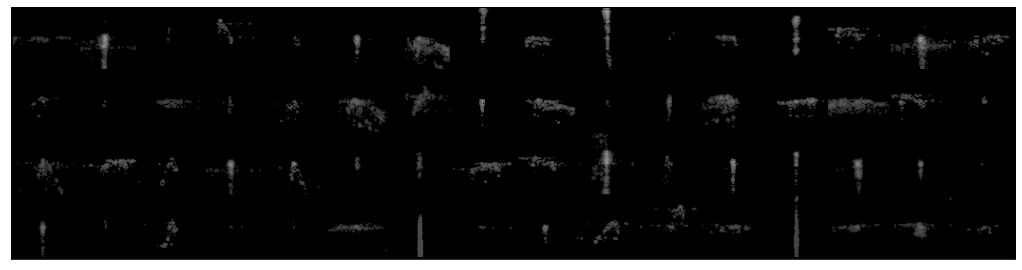

In [9]:
for images, labels in data_loader:
    print(images.shape)
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

## - Generator

In [10]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        
        # Reshape z
        z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([z, c], 1)
        
        # Generator out
        out = self.model(x)
        
        return out.view(-1, self.img_size, self.img_size)

## - Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        
        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([x, c], 1)
        
        # Discriminator out
        out = self.model(x)
        
        return out.squeeze()

In [12]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

## - Adversarial Learning of Generator & Discriminator

In [13]:
# Loss function
criterion = nn.BCELoss()

In [14]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [15]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [16]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    # Init gradient 
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)
    
    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # Sum two losses
    d_loss = real_loss + fake_loss
    
    # Backword propagation
    d_loss.backward()
    
    # Optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

Starting epoch 1...
g_loss: 2.5114564895629883, d_loss: 1.1176780462265015


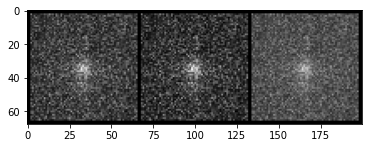

Starting epoch 2...
g_loss: 7.534670829772949, d_loss: 0.15231117606163025


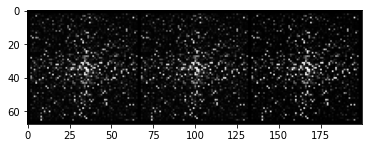

Starting epoch 3...
g_loss: 2.5074501037597656, d_loss: 0.515413761138916


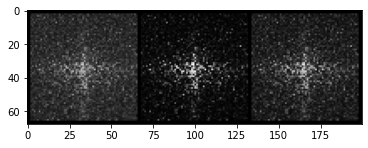

Starting epoch 4...
g_loss: 3.041405439376831, d_loss: 0.7029145956039429


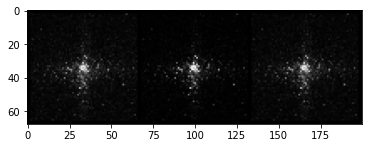

Starting epoch 5...
g_loss: 0.7877607345581055, d_loss: 1.9759409427642822


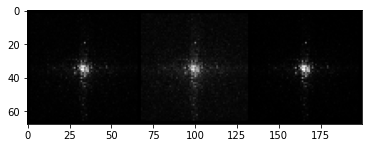

In [17]:
for epoch in range(epochs):
    
    print('Starting epoch {}...'.format(epoch+1))
    
    for i, (images, labels) in enumerate(data_loader):
        
        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        # Set generator train
        generator.train()
        
        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        
        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
    
    # Set generator eval
    generator.eval()
    
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    
    # Building z 
    z = Variable(torch.randn(class_num, z_size)).to(device)
    
    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)
    
    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    
    # Show images
    grid = make_grid(sample_images, nrow=4, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

## - Show Generating Images

tensor([[-0.8750, -1.1447,  0.6671,  ...,  0.0428,  1.2794, -2.0794],
        [-0.3965, -0.3059, -0.5784,  ..., -1.3869,  0.8392,  0.9367],
        [ 0.9132, -0.4561, -0.8357,  ...,  0.3829, -0.3272,  0.8127],
        ...,
        [-0.0113, -0.5953,  0.7104,  ...,  1.5785,  0.9986,  1.4073],
        [ 1.3101, -1.7554,  1.8070,  ..., -1.0420, -0.7718,  1.4215],
        [-0.1971,  0.6366,  0.6842,  ..., -0.6857,  1.0350,  0.6282]],
       device='cuda:0')
tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3], device='cuda:0')


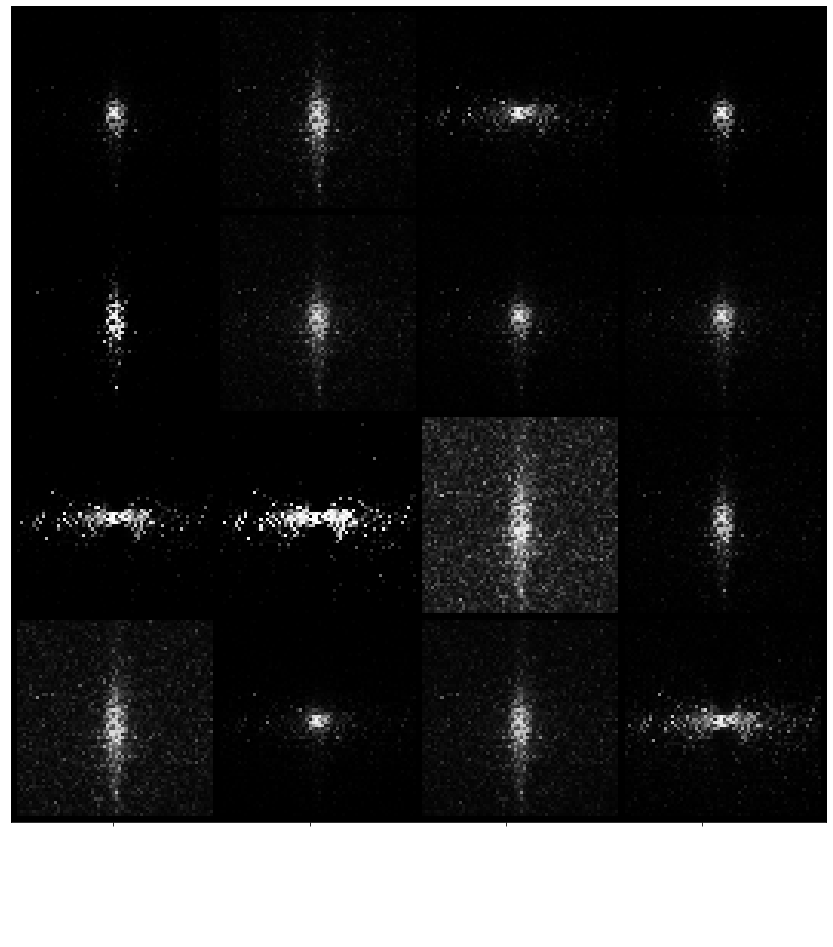

In [84]:
# Building z 
z = Variable(torch.randn(16, z_size)).to(device)
print(z)
# Labels 0 ~ 9
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)
print(labels)
# Generating images
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(33, 256, 64), class_list, rotation=45, fontsize=20,color="w")